# Toy example : Parameter estimation with $Ma(q)$

## Definition of the model
$$x_{t}=\mu+\epsilon_{t}-\sum_{i=1}^{q} \vartheta_{i} \epsilon_{t-i}$$

In [1]:
import numpy as np

def MAq(t, n_obs=10000, batch_size=1, random_state=None):
    # Make inputs 2d arrays for numpy broadcasting with w
    s = t.shape[1]
    assert t.shape[0] == batch_size
    w = np.random.randn(batch_size, n_obs+s)  # i.i.d. sequence ~ N(0,1)
    x = w[:,s:]
    for p in range(s):
        x = x + np.repeat(np.reshape(t[:,p],(batch_size,1)),n_obs,axis=1)*w[:, (s-p-1):(-p-1)]
    return x


## Priors constraint

For identifiability reasons, 

$$\mathcal{Q}(u)=1-\sum_{i=1}^{q} \vartheta_{i} u^{i}$$

should have only roots outside of the (complex) unity disc.

In [2]:
import math

def generate_maq_priors(q,min,max,batch_size=1):
    d = q // 2
    if (q % 2) == 0:
        d = d - 1
    nc = np.random.randint(q,size=batch_size)
    nd = np.random.randint(d,size=batch_size)
    r = np.random.uniform(min,max,(batch_size,1))
    genr = np.exp(np.random.dirichlet(np.ones(q),batch_size)*np.log(np.abs(1/r)))
    # genr = genr * randSign(q,(r <= 0),batch_size)
    genr[:,-1] = -genr[:,-1]
    alphas = np.zeros((batch_size,q))
    for i in range(batch_size):
        gen = np.random.uniform(0,math.pi,nd[i])
        d2 = (q - (2*nd[i])) // 2
        if (q % 2) == 0:
            d2 = d2 - 1
        nq =  np.random.randint(d2)
        alphas[i,:nd[i]] = gen
        alphas[i,nd[i]:(2*nd[i])] = -gen
        alphas[i,-(2*nq+1):] = -1
    roots = np.zeros((batch_size,q),dtype=complex)
    roots.real = np.cos(alphas) 
    roots.imag = np.sin(alphas)
    if (q % 2) != 0:
        roots[:,nc] = -roots[:,nc]
    roots = roots / genr
    assert np.min(np.abs(roots)) > 1
    poly = np.apply_along_axis(np.polynomial.polynomial.polyfromroots,1,roots).real[:,1:]
    return poly * np.reshape(r,(batch_size,1))

## Summary statistics 

Autocorrelations with lag from 1 to $p \ge q$ is recommended for $Ma(q)$ models.

In [3]:
from statsmodels.tsa.stattools import acf

def autocorr(x, to=1):
    C = np.zeros((x.shape[0],to))
    for i in range(x.shape[0]):
        C[i] = acf(x[i],True,nlags=to,fft=True)[1:]
    return C


## The observed data
generated by us, of course...

Thetas :  [  5.35156601 -14.04747799  11.69697049  22.91983115 -77.59168038
 104.79499532 -81.92546714  38.66279738 -10.28606669   1.19120751]


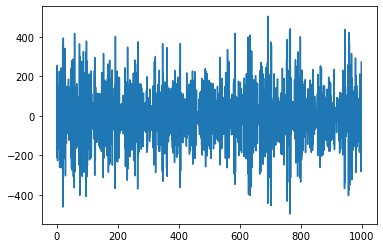

In [4]:
import matplotlib.pyplot as plt
minprior = 1
maxprior = 2
Ny = 1000
Ncov = 20
q = 10
nref = 2000
batchsize = 1000

modsimple = generate_maq_priors(q,minprior,maxprior)
y_obs = MAq(modsimple,Ny)
plt.figure()
plt.plot(y_obs[0])
print('Thetas : ', modsimple[0])

## Setting the ABC pipeline

In [5]:
import elfi

### Wrapping priors, custom classes

In [6]:
class GlobalPrior(elfi.Distribution):
    def rvs(q,min,max,size=1,random_state=None):
        return generate_maq_priors(q,min,max,size[0])

class DependantPrior(elfi.Distribution):
    def rvs(t,size=1,random_state=None):
        return np.mean(np.abs(t),axis=1) 

First stages, prior dependancies

In [7]:
t  = elfi.Prior(GlobalPrior,q,minprior,maxprior)
tm = elfi.Prior(DependantPrior,t)

Final stages, summary stats, simulator and distance

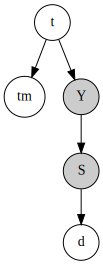

In [8]:
Y = elfi.Simulator(MAq,t, observed=y_obs)
S = elfi.Summary(autocorr,Y,Ncov)
d = elfi.Distance('euclidean',S)
elfi.draw(d)

In [9]:
elfi.set_client('multiprocessing')
rej = elfi.Rejection(d,batch_size=batchsize,output_names=['S'])

### ABC samping

In [10]:
print('ABC sampling + rejection')
result = rej.sample(nref,threshold=100)

ABC sampling + rejection
Progress: |██████████████████████████████████████████████████| 100.0% Complete


# AbcRanger, posterior Parameter Estimation

In [11]:
import sys
sys.path.insert(0,'../build')
import pyabcranger

def listvar(prefix,s):
    return [prefix+str(i) for i in range(1,s+1)]

rf = pyabcranger.reftable(
    nref,
    [0],
    [q],
    listvar('t',q) + ['tm'],
    listvar('S',Ncov),
    result.outputs['S'],
    result.samples_array,
    np.ones(nref)
)

In [12]:
from tqdm import tqdm

def estimparam_args(i):
    if (i == q + 1):
        l = 'm'
    else: 
        l = str(i)
    return " ".join(['-n ',str(nref),'--ntree 500','--parameter t' + l,'--noob 0','--chosenscen 1'])
# Parameter estimation for all parameters thetas
postres = [pyabcranger.estimparam(rf,S.observed[0],estimparam_args(i),True,False) for i in tqdm(range(1,q+2))]

100%|██████████| 11/11 [00:03<00:00,  3.31it/s]


### Scoring

In [13]:
reality = np.r_[modsimple[0],[np.mean(np.abs(modsimple[0]))]]

print('Scores : ')
print('NMAE abc + mean : ',np.mean(np.abs((reality-np.mean(result.samples_array,axis=0))/reality)))
print('NMAE abc + rf   : ',np.mean(np.abs((reality-np.array([postres[i].point_estimates['Expectation'] for i in range(q+1)]))/reality)))

Scores : 
NMAE abc + mean :  0.7431826904631994
NMAE abc + rf   :  0.37365202463296343


### Posterior distributions

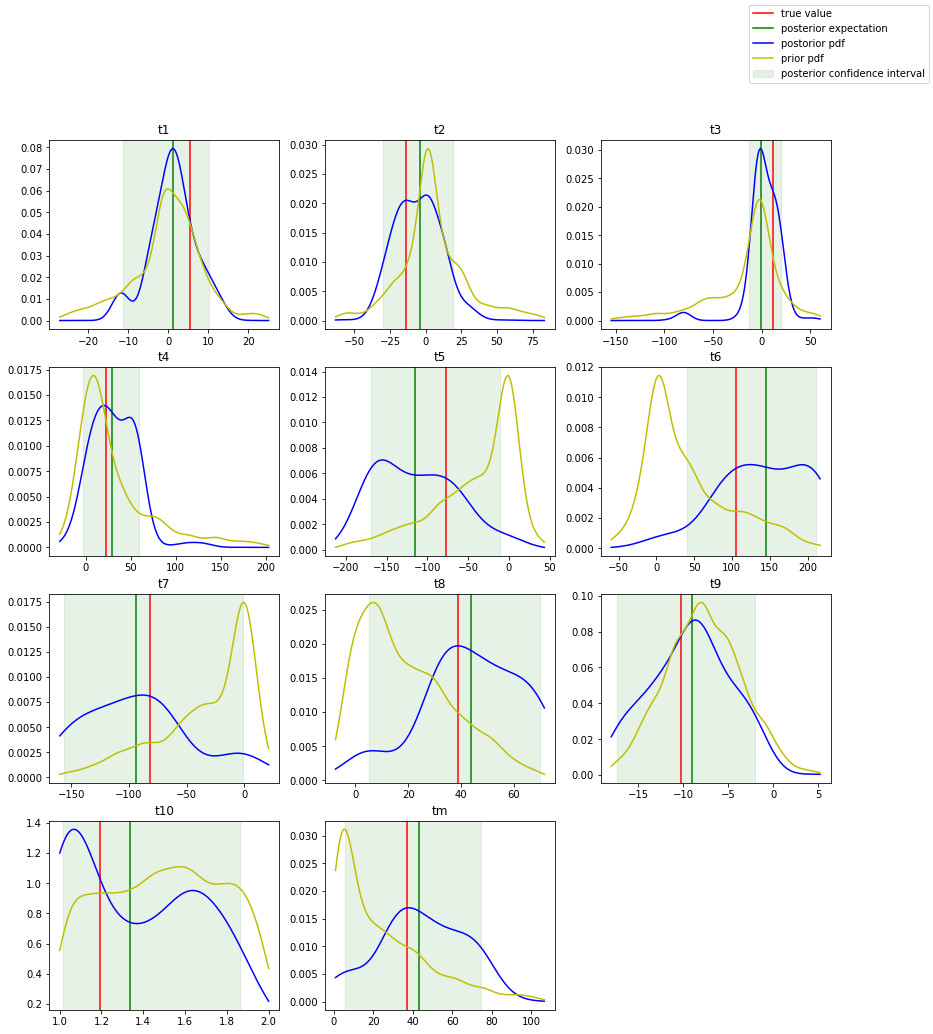

In [14]:
from scipy.stats import gaussian_kde
columns = 3
rows = ((q + 1) // columns) + 1
fig, axs = plt.subplots(rows,columns,figsize=(14, 16))
for i in range(columns * rows):
    ax = axs[i // columns, i % columns]
    if (i >= q + 1):
        ax.axis('off')
    else:
        x,y = np.asanyarray(postres[i].values_weights)[:,0],np.asanyarray(postres[i].values_weights)[:,1]
        pdfw = gaussian_kde(x,weights=y)
        pdf = gaussian_kde(x)
        xp = np.linspace(np.min(x),np.max(x),200)
        if (i == q):
            l = 'm'
        else: 
            l = str(i+1)
        ax.set_title('t' + l)
        ax.axvline(x=reality[i], color='r')
        ax.axvline(postres[i].point_estimates['Median'], color='g')
        ax.axvspan(postres[i].point_estimates['Quantile_0.05'],postres[i].point_estimates['Quantile_0.95'],alpha=0.1,color='g')
        ax.plot(xp,pdfw(xp),color="b")
        ax.plot(xp,pdf(xp),color="y")
        
fig.legend(['true value','posterior expectation','postorior pdf','prior pdf','posterior confidence interval']);